In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mesa_tricks.io import read_track, read_freqs
from mesa_tricks.utils import memoise, match_modes, tqdm_parallel_map

In [2]:
props_obs = {
    'L': 174.6,
    'e_L': 10,
    'effective_T': 4318.047,
    'e_effective_T': 80,
    'FeH': -0.21,
    'e_FeH': 0.08,
    'Δν': 1.232,
    'e_Δν': 0.011,
    'nu_max': 7.5,
    'e_nu_max': .3,
}

In [3]:
# Direct method M and R

from astropy import units as u, constants as c

def direct_method(nu_max, Δν, effective_T, e_nu_max, e_Δν, e_effective_T, **kwargs):
    
    f_Δν = 0.97 # from Sharma et al. 2016
    
    M = (nu_max / 3090)**3 / (Δν / 135 / f_Δν)**4 * np.power(effective_T/5772, 3/2)
    R = (nu_max / 3090)**1 / (Δν / 135 / f_Δν)**2 * np.power(effective_T/5772, 1/2)
    
    e_M = M * np.sqrt((3 * e_nu_max / nu_max)**2 + (4 * e_Δν / Δν * f_Δν)**2 + (3/2 * e_effective_T / effective_T)**2)
    e_R = R * np.sqrt((1 * e_nu_max / nu_max)**2 + (2 * e_Δν / Δν * f_Δν)**2 + (1/2 * e_effective_T / effective_T)**2)
    print(f"M = {M:.3f} ± {e_M:.3f}; R = {R:.3f} ± {e_R:.3f}, log_g = {np.log10((c.G * M * u.M_sun / (R * u.R_sun)**2).cgs.value):.3f}")
    
direct_method(**props_obs)

M = 1.181 ± 0.151; R = 23.718 ± 1.057, log_g = 1.760


In [4]:
import pandas as pd

df = pd.read_csv("freqs.csv")

modes_obs = {_: df[_].values for _ in ['l', 'ν', 'e_ν', 'n']}

In [5]:
from os import system
from os.path import isdir, isfile
from mesa_tricks.opt import Δν_fit
from mesa_tricks.costs import low_n_cost, ε_cost, bgcost
import warnings

from tqdm.auto import tqdm

GS98_ZX = 0.0229
GYRE_DIR = "~/Git/gyre"
RUN_MESA = True
N_LOW_MODES = 3

def pulse(gyrefile):

    outname = gyrefile.replace(".data.GYRE", ".freqs")
    if not isfile(outname):
        with open("gyre.template", 'r') as f:
            template = f.read()

        output = template.format(fname=gyrefile,
                                 outname=outname)

        with open("gyre.in", "w") as f:
            f.write(output)

        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            system(f"{GYRE_DIR}/bin/gyre ./gyre.in &> /dev/null")

    return read_freqs(outname)

def χ2_seis_single(track, profile, props=False, trace=False):
    modes = pulse(f"tracks/LOGS_{track}/profile{profile}.data.GYRE")
    
    m0 = modes['l'] == 0
    ν0 = modes['ν'][m0]
    n0 = modes['n_p'][m0]
    
    if len(n0) == 0:
        return np.inf
    
    Δν_model, *_ = Δν_fit(ν0, n0)
    
#     if np.abs(Δν_model - props_obs['Δν']) > props_obs['Δν'] / len(ν0):
#         return np.inf
    
    matched = match_modes(modes_obs, modes, force_mod=False)
    if len(matched['ν_obs']) != len(modes_obs['ν']):
        return np.inf

    χ2_bg14, _ = bgcost(
        ν_obs=matched['ν_obs'], e_obs=matched['e_obs'],
        ν_model=matched['ν_model'], inertia=matched['E'],
        l=matched['ll'], l0_only=True, trace=trace
    )
    
    χ2_ε = ε_cost(
        matched['ν_obs'], matched['e_obs'],
        matched['ν_model'], matched['n_p'],
        matched['ll'], props_obs['Δν']
    )
    
    χ2_low_n_1 = low_n_cost(matched['ν_obs'], matched['e_obs'], matched['ν_model'], n=N_LOW_MODES)
    χ2_low_n_2 = low_n_cost(-matched['ν_obs'], matched['e_obs'], -matched['ν_model'], n=N_LOW_MODES)
    
    return χ2_ε + (χ2_low_n_1 + χ2_low_n_2)/10

def χ2_spec(props):
    return sum((props_obs[_] - props[_])**2 / props_obs[f"e_{_}"]**2
               for _ in props_obs if _[:2] != 'e_' and _ not in ['Δν', 'nu_max'])

def safe_apply(ufunc, arr, *args, **kwargs):
    try:
        return ufunc(arr, *args, **kwargs)
    except ValueError:
        return np.full_like(arr, np.nan)

@memoise
def cost(*params, ID=0, reset=False, trace=False, props=False):
    
    M, Y, Z, α_mlt = params

    if reset or not isdir(f"tracks/LOGS_{ID}"):
        if RUN_MESA:
            system(f"./dispatch.sh {ID} {M} {Y} {Z} {α_mlt} >| logs/{ID}.mesa.log")
        
    try:
        track = read_track(f"tracks/LOGS_{ID}")
    except FileNotFoundError:
        return np.inf

    track['FeH'] = track['log_surf_cell_z'] - track['log_surface_h1'] - np.log10(GS98_ZX)
    track['L'] = np.power(10, track['log_L'])
    
    spec = np.array(χ2_spec(track))
    seis = np.array([χ2_seis_single(ID, profile) for profile in track.profile])
    
    χ2_total = spec + seis
    
    if trace:
        i0 = np.argmin(χ2_total)
        χ2_seis_single(ID, np.array(track.profile)[i0], trace=True)
        
    if props:
        
        seis_props = np.array([χ2_seis_single(ID, profile, props=True) for profile in track.profile])
        return {
            'χ2_spec': spec,
            'χ2_seis': seis,
            'χ2_total': χ2_total,
            
            # stellar properties of interest

            'M': np.array(track['star_mass']),
            'R': np.power(10, np.array(track['log_R'])),
            't': np.array(track['star_age']),
            'Y': np.full(len(track), Y),
            'Z': np.full(len(track), Z),
            'α_mlt': np.full(len(track), α_mlt),
            'dt': safe_apply(np.gradient, np.array(track['star_age']))
        }
        
    return np.min(χ2_total)

In [ ]:
from yabox import DE

def job(p):
    return cost(*p)

problem = DE(job, [[1.05, 1.3], [0.248, 0.32], [0.008, 0.02], [1.7, 2.1]],
             maxiters=100, seed=42)
soln = problem.solve(show_progress=True)
soln

Optimizing (DE):   0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
store = np.load("memo.npy", allow_pickle=True)[()]
params = np.array(list(store.keys()))
RUN_MESA = False

acc = [cost(*p, props=True) for p in tqdm(params)]
# acc = tqdm_parallel_map(lambda p: cost(*p, props=True), params, nthreads=16)
keys = list(acc[0].keys())

  0%|          | 0/2293 [00:00<?, ?it/s]

In [17]:
best_track = np.argmin([np.min(_['χ2_total']) for _ in acc if _ != np.inf])
best_profile = np.argmin(acc[best_track]['χ2_total'])

print(f"{best_track}_{best_profile+1}")

1099_96


{'model_number': 2646.0, 'num_zones': 3030.0, 'star_age': 4514447387.715055, 'star_mass': 1.1759154273285848, 'mass_conv_core': 0.0, 'he_core_mass': 0.30542585902868113, 'c_core_mass': 0.0, 'o_core_mass': 0.0, 'si_core_mass': 0.0, 'fe_core_mass': 0.0, 'neutron_rich_core_mass': 0.0, 'effective_T': 4334.1162626757405, 'luminosity': 176.41696656464805, 'log_L': 2.2465403502462946, 'log_R': 1.3727278973953043, 'log_g': 1.7628096467186838, 'log_surf_cell_z': -2.003253731406192, 'v_div_csound_surf': 3.064588320590925e-09, 'log_surface_h1': -0.1635329666127645, 'delta_nu': 1.4152704535774276, 'delta_Pg': 48.54080464896829, 'nu_max': 7.538408676233389, 'priority': 1.0, 'profile': 90.0}
{'χ2_spec': 0.09040323385835129, 'χ2_seis': 12.445820158574769, 'χ2_total': 12.53622339243312, 'M': 1.1759154273285848, 'R': 23.58999763769525, 't': 4514447387.715055, 'Y': 0.28896373514659385, 'Z': 0.009932090268232387, 'α_mlt': 1.8637475014628295, 'dt': 27894.020792007446}
L: 176.41696656464794
Teff: 4334.1162

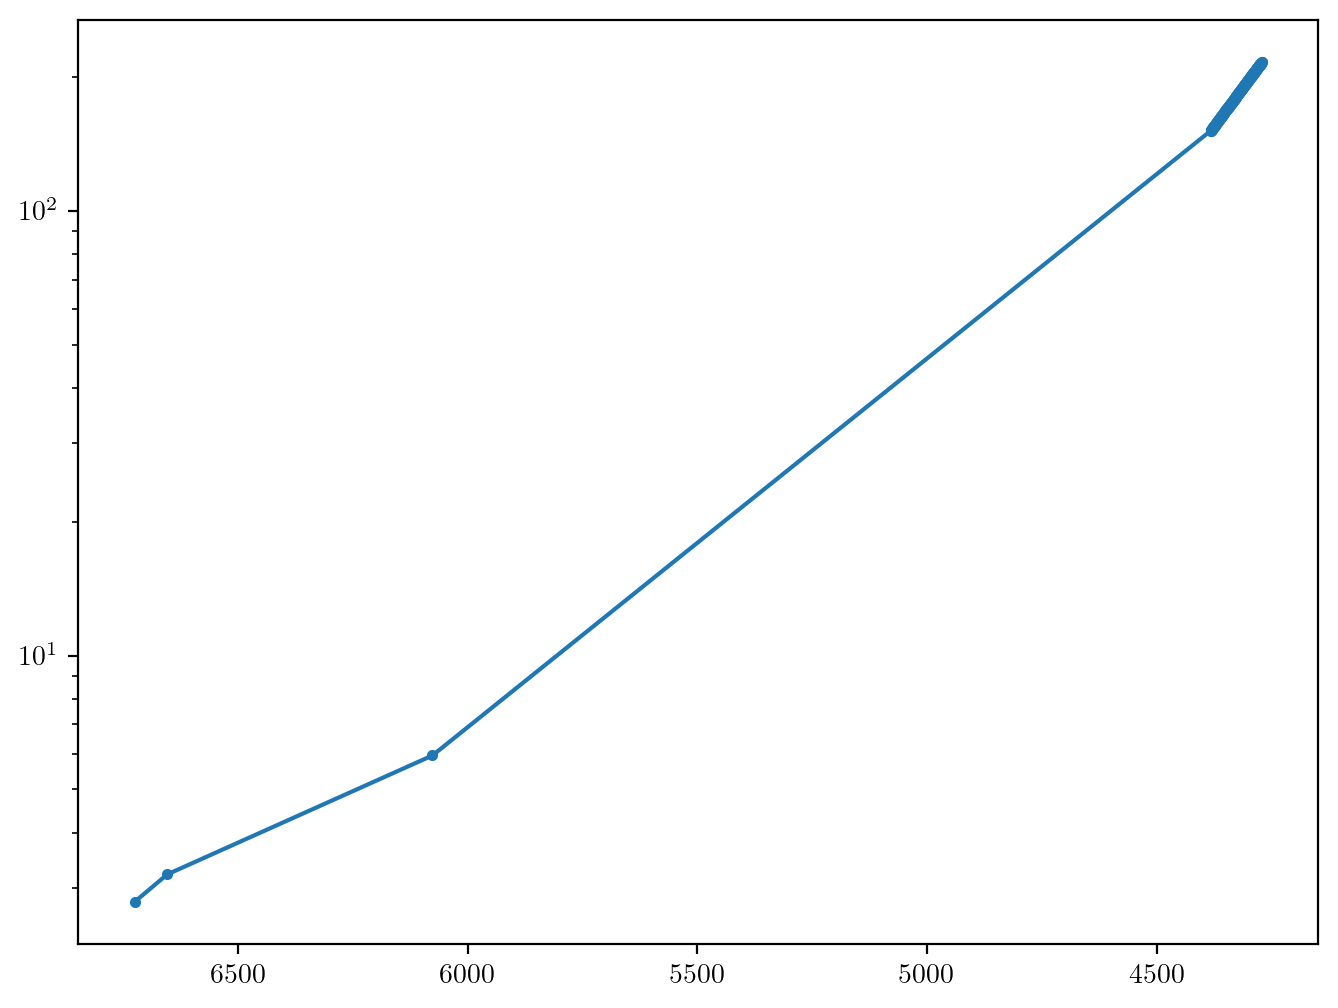

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


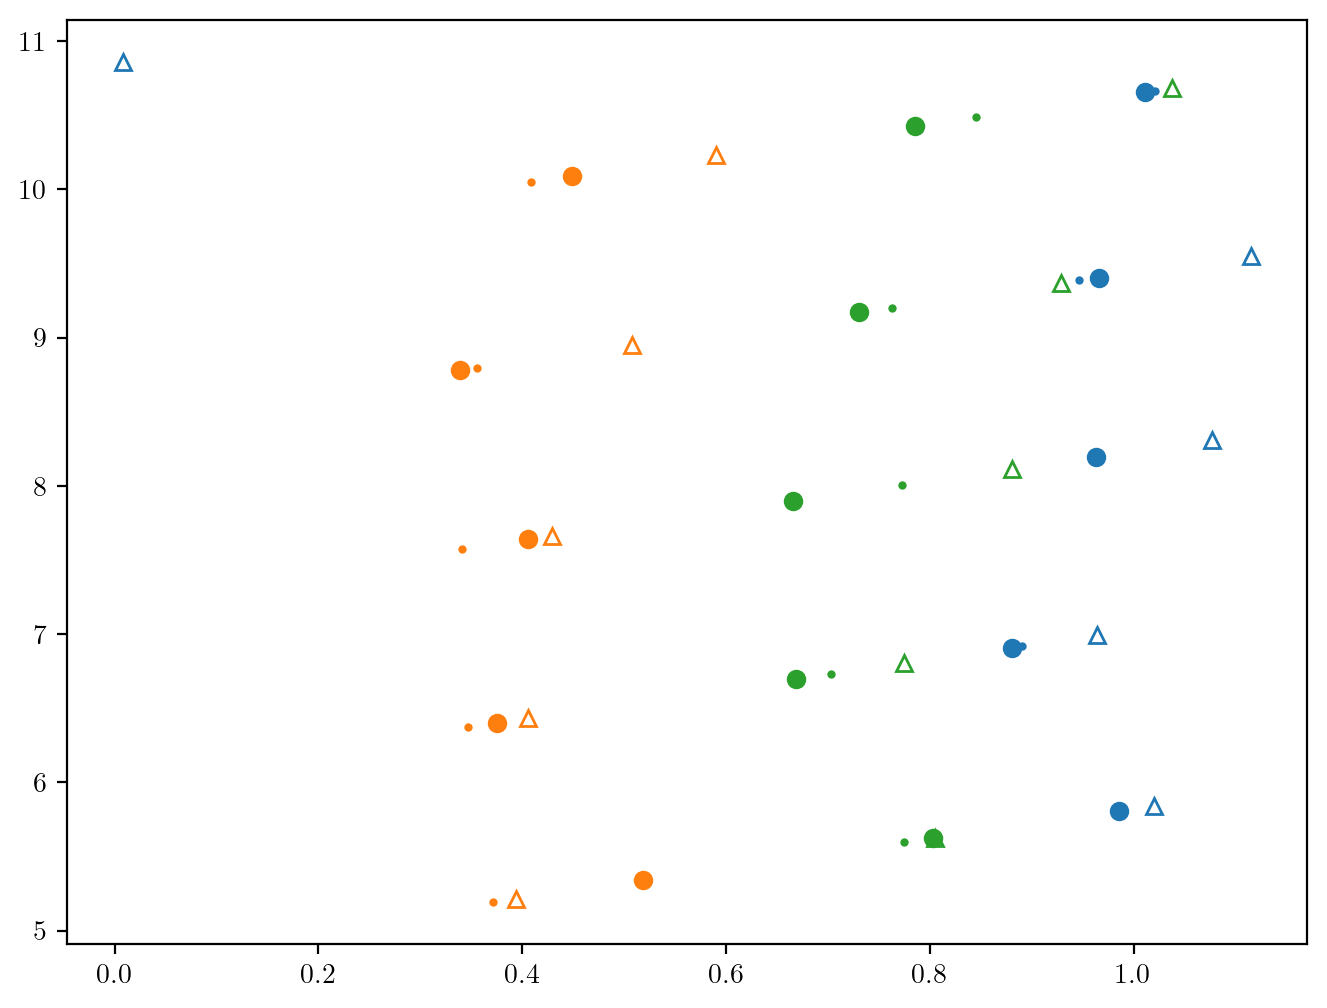

In [39]:
from mesa_tricks.science import bg_fit
import pandas as pd

def summarise(best_profile, best_track):
    df = read_track(f"tracks/LOGS_{best_track}")
    props_best = df.iloc[best_profile].to_dict()
    params_best = {_: acc[best_track][_][best_profile] for _ in acc[0]}
    
    print(props_best)
    print(params_best)
    
    # 1. prepare list of L, Teff, and [M/H] 
    
    print(f"L: {np.power(10, props_best['log_L'])}")
    print(f"Teff: {props_best['effective_T']}")
    print(f"[M/H]: {props_best['log_surf_cell_z'] - props_best['log_surface_h1'] - np.log10(GS98_ZX)}")
    
    plt.plot(df.effective_T, np.power(10, df.log_L), '.-')
    plt.gca().invert_xaxis()
    plt.gca().set_yscale('log')
    plt.show()
    
    # 2. get frequencies
    
    modes = pulse(f"tracks/LOGS_{best_track}/profile{int(props_best['profile'])}.data.GYRE")
    matched = match_modes(modes_obs, modes)
    
    # 3. apply bg14 correction
    
    m = matched['ll'] == 0
    _, _, residual = bg_fit(matched['ν_obs'][m],
                            matched['ν_model'][m],
                            matched['E'][m],
                            σ_ν=matched['e_obs'][m])
    
    χ2, ρ = bgcost(matched['ν_obs'], matched['e_obs'], matched['ν_model'], matched['E'], l=matched['ll'], l0_only=True)
    
    def correct(ν_model, E, am1, a3):
        return ν_model + (am1/ν_model + a3 * ν_model**3) / E
    
    ν_c = matched['ν_obs'] - residual(matched['ν_obs'], matched['ν_model'], matched['E'])
    print(correct(matched['ν_model'], matched['E'], *ρ) - ν_c)

    Δν = np.median(np.diff(matched['ν_obs']))     
    for l in (0, 1, 2):
        m = matched['ll'] == l
        plt.plot(matched['ν_obs'][m] % Δν, matched['ν_obs'][m], 'o', c=f"C{l}")
        plt.plot(matched['ν_model'][m] % Δν, matched['ν_model'][m], '^', c=f"C{l}", markerfacecolor='none')
        plt.plot(ν_c[m] % Δν, ν_c[m], '.', c=f"C{l}", markeredgecolor='none')
        
    corrected = {'l': modes['l'], 'raw': modes['ν'], 'corrected': correct(modes['ν'], modes['E'], *ρ)}
    pd.DataFrame(corrected).to_csv("for_travis.csv", index=False)
    
summarise(best_profile-6, best_track)

In [9]:
props_consolidated = {_: np.concatenate([a[_] for a in acc if a != np.inf]) for _ in acc[0]}
np.save("props.npy", props_consolidated)

### Estimate sampling function

In [10]:
from scipy.stats import gaussian_kde

k = gaussian_kde(params.T)

sampling_function = k(
    np.array([props_consolidated['M'],
    props_consolidated['Y'],
    props_consolidated['Z'],
    props_consolidated['α_mlt']])
)
sampling_function = sampling_function / props_consolidated['dt']

In [11]:
inv_sampling_function = np.nan_to_num(1/sampling_function)

In [ ]:
likelihood_weights = np.nan_to_num(inv_sampling_function * np.exp(-props_consolidated['χ2_total']/2))

from corner import corner

plt.close('all')
m_support = (likelihood_weights > 0)
corner(
    np.array([props_consolidated[_][m_support] for _ in ['M', 'Y', 'Z', 'α_mlt', 'R', 't']]).T,
    weights=likelihood_weights[m_support],
    bins=10,
    labels=['$M/M_\\odot$', "$Y_i$", "$Z_i$", "$\\alpha_\mathrm{MLT}$", "$R/R_\\odot$", "Age/yr"]
)
plt.savefig(r"corner_01_ong.png", bbox_inches='tight', transparent=True, dpi=150)
plt.show()

In [14]:
from wquantiles import quantile

In [36]:
from scipy.stats import norm

with open("summary.txt", 'w') as f:
    def fprint(*a, **b):
        print(*a, **b)
        f.write(*a, **b)
        f.write("\n")

    q0 = [norm.cdf(_) for _ in (-1, 0, 1)]
    for _ in ['M', 'Y', 'Z', 'α_mlt', 'R', 't']:
        qs = [quantile(props_consolidated[_], likelihood_weights, __) for __ in q0]
        if _ == 't':
            qs = [__/1e9 for __ in qs]
        fprint("{}: {:.3e}, {:.3e}, {:.3e}".format(_, *qs))
        print(f"{_}: {qs[1]:.3f} + {qs[2]-qs[1]:.3f} - {qs[1]-qs[0]:.3f}")


M: 1.109e+00, 1.140e+00, 1.189e+00
M: 1.140 + 0.049 - 0.031
Y: 2.543e-01, 2.734e-01, 3.001e-01
Y: 0.273 + 0.027 - 0.019
Z: 9.220e-03, 1.038e-02, 1.124e-02
Z: 0.010 + 0.001 - 0.001
α_mlt: 1.803e+00, 1.885e+00, 2.003e+00
α_mlt: 1.885 + 0.118 - 0.082
R: 2.325e+01, 2.348e+01, 2.385e+01
R: 23.481 + 0.366 - 0.228
t: 4.579e+00, 5.423e+00, 6.411e+00
t: 5.423 + 0.988 - 0.845
